# Course : Human Data Analytics
# Project : Sleep posture monitoring (A3)

## Marc Antoine BERRET

# Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
cd 'drive/MyDrive/HDA_project/'

/content/drive/MyDrive/HDA_project


In [ ]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

import tensorflow as tf
import keras
from tensorflow.keras.utils import plot_model
from timeit import default_timer as timer

from sklearn.model_selection import KFold

from cnn_models import *

 # 1 - Data loading and preprocessing

I used the first experiment from the public dataset
PmatData. Data is collected using Vista Medical FSA Soft-
Flex 2048.

The dataset contains 13 files corresponding to
the 13 participants, with each file containing 17 documents
corresponding to the 17 postures (8 standard postures and
9 additional uncommon postures).

Each document contains several pressure matrices collected at a sampling rate of 1Hz. Each row is a new pressure matrix of size 64x32, and the
sensors report numbers in the range [0-1000].

What we need to do first is transform the data. In fact, we're going to create a data directory and associate each 64x32 matrix with a reference array containing all the labels.

More information about the dataset can be found here: https://physionet.org/content/pmd/1.0.0/


## 1.1 - Transform raw_data in intuitive data

In [ ]:
def transform_raw_data(raw_data_path = '/content/drive/MyDrive/HDA_project/raw_data'):

  """
   Arguments:
   raw_data_path -- path of the raw data

   Returns:
   - create a file for each image
   - create and save a dataframe (reference_df) which contains the id_image and the labels (subject and posture)
   """

  #initialisation of the variables
  column_id_image = []
  column_subject_label = []
  column_posture_label = []
  id_image = 0

  #for each subject#
  for subject_folder in os.listdir(raw_data_path):

    #change the current path to the individual folder path
    subject_folder_path = os.path.join(raw_data_path, subject_folder) #(we have 13 different subjects)
    #get the number of subject_label
    subject_label = int(subject_folder_path.split('/S')[1])

    #for each posture
    for file_name in os.listdir(subject_folder_path):

      #change the individual folder path to the file path (posture path)
      file_path = os.path.join(subject_folder_path, file_name) #(we have 17 different postures)

      #there are some steps to just get the number of posture_label
      posture_label = file_name.split('/')
      posture_label = posture_label[-1].split('.')[0]

      #get the file data with Numpy
      file_data = np.loadtxt(file_path)

      #for each image (we remove the first and last 3 due to noise)
      for i in range(3,file_data.shape[0]-2):

        #update id_image
        id_image = id_image + 1

        #create a new file for each image and reshape the data
        np.savetxt(f'/content/drive/MyDrive/HDA_project/data/{id_image}.txt',file_data[i].reshape((64,32)), fmt='%d', delimiter='\t')

        #add id_image, subject_label, posture_label to the appropriate list to create after reference_df
        column_id_image.append(id_image)
        column_subject_label.append(subject_label)
        column_posture_label.append(posture_label)

  #at the end we create and save the reference_df
  dict = {'id_image': column_id_image,
          'subject_label': column_subject_label,
          'posture_label': column_posture_label}

  reference_df = pd.DataFrame(dict)
  reference_df.to_csv('/content/drive/MyDrive/HDA_project/reference.csv')

In [ ]:
#transform_raw_data()

For reasons of efficiency, I've manually converted the data file into a zip file, and we can now read our data with the command below:

In [ ]:
!unzip "data.zip" -d ""

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: data/5499.txt           
  inflating: data/55.txt             
  inflating: data/550.txt            
  inflating: data/5500.txt           
  inflating: data/5501.txt           
  inflating: data/5502.txt           
  inflating: data/5503.txt           
  inflating: data/5504.txt           
  inflating: data/5505.txt           
  inflating: data/5506.txt           
  inflating: data/5507.txt           
  inflating: data/5508.txt           
  inflating: data/5509.txt           
  inflating: data/551.txt            
  inflating: data/5510.txt           
  inflating: data/5511.txt           
  inflating: data/5512.txt           
  inflating: data/5513.txt           
  inflating: data/5514.txt           
  inflating: data/5515.txt           
  inflating: data/5516.txt           
  inflating: data/5517.txt           
  inflating: data/5518.txt           
  inflating: data/5519.txt           
  inflatin

## 1.2 - Import labels

In [ ]:
reference_df = pd.read_csv('/content/drive/MyDrive/HDA_project/reference.csv',names=['id_image','subject_label','posture_label'])
reference_df = reference_df.drop(index=reference_df.index[0], axis=0) #drop first column
reference_df = reference_df.set_index('id_image') #set index
reference_df.index.name = None #remove the name of the index

#convert string label to int
reference_df['subject_label'] = reference_df['subject_label'].astype(int)
reference_df['posture_label'] = reference_df['posture_label'].astype(int)

#we want that the label start from 0 and not from 1 (substantial for model.fit())
reference_df['subject_label'] = reference_df['subject_label']-1
reference_df['posture_label'] = reference_df['posture_label']-1
print(reference_df)

       subject_label  posture_label
1                  0              0
2                  0              0
3                  0              0
4                  0              0
5                  0              0
...              ...            ...
18915              8              8
18916              8              8
18917              8              8
18918              8              8
18919              8              8

[18919 rows x 2 columns]


In [ ]:
#get the string labels
string_posture_label = ['Supine','Right','Left','Right 30°-roll','Right 60°-roll','Left 30°-roll','Left 60°-roll','Supine star','Supine Hand Crossed','Supine Knees up','Supine Right Knee up','Supine Left Knee up','Right Fetus','Left Fetus','Supine 30° Bed Inclination','Supine 45° Bed Inclination','Supine 60° Bed Inclination']

#create a new column that associate the posture_label with the string_posture_label
def map_to_list(value):
    return string_posture_label[value]
reference_df['string_posture_label'] = reference_df['posture_label'].apply(map_to_list)
print(reference_df)

       subject_label  posture_label string_posture_label
1                  0              0               Supine
2                  0              0               Supine
3                  0              0               Supine
4                  0              0               Supine
5                  0              0               Supine
...              ...            ...                  ...
18915              8              8  Supine Hand Crossed
18916              8              8  Supine Hand Crossed
18917              8              8  Supine Hand Crossed
18918              8              8  Supine Hand Crossed
18919              8              8  Supine Hand Crossed

[18919 rows x 3 columns]


In [ ]:
value_counts_subject_label = reference_df['subject_label'].value_counts().sort_values()
value_counts_posture_label = reference_df['string_posture_label'].value_counts().sort_values()

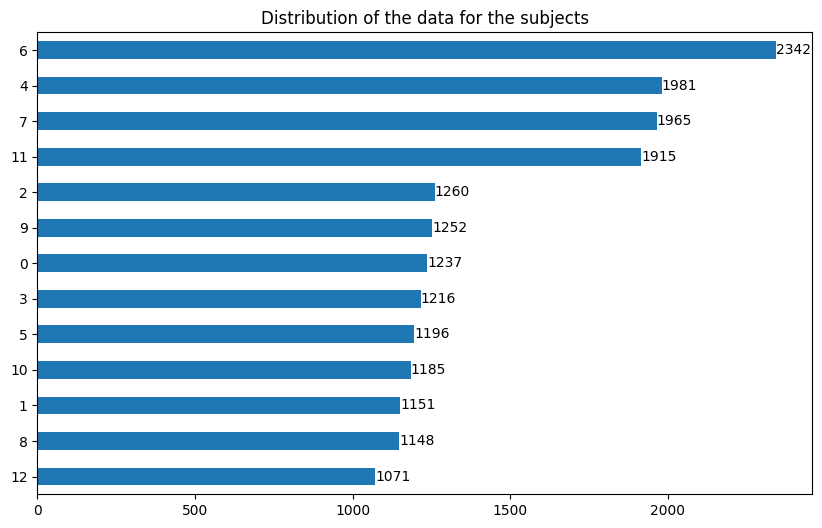

In [ ]:
plt.figure(figsize=(10, 6))

value_counts_subject_label.plot(kind='barh')
plt.title('Distribution of the data for the subjects')

for index, value in enumerate(value_counts_subject_label):
    plt.text(value, index, str(value), ha='left', va='center', fontsize=10)

plt.show()
plt.close()

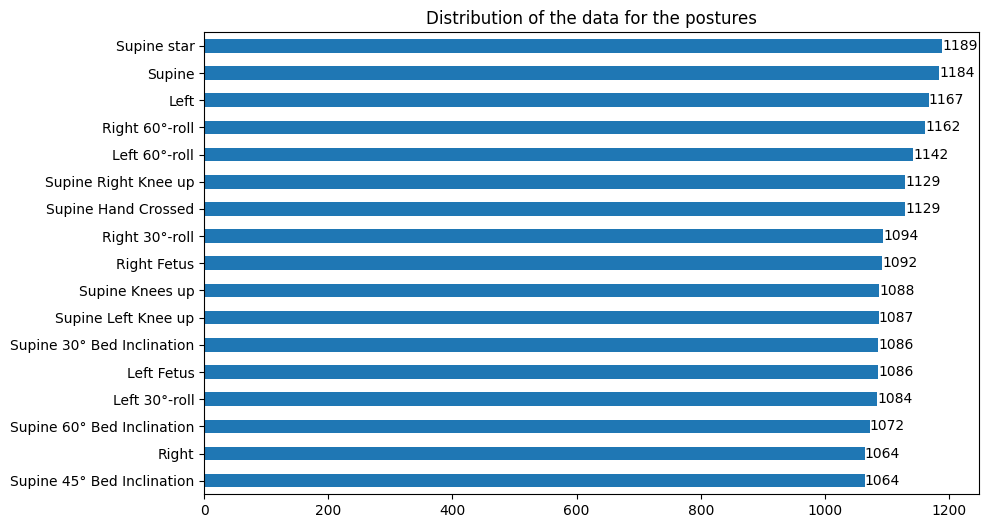

In [ ]:
plt.figure(figsize=(10, 6))

value_counts_posture_label.plot(kind='barh')
plt.title('Distribution of the data for the postures')

for index, value in enumerate(value_counts_posture_label):
    plt.text(value, index, str(value), ha='left', va='center', fontsize=10)

plt.show()
plt.close()

## 1.3 - Create training set, validation set and test set

In [ ]:
# 70% training set, 20% validation set and 10% test set

train_val_reference_df, test_reference_df = train_test_split(reference_df, train_size=0.9, random_state=123)
train_reference_df, val_reference_df = train_test_split(train_val_reference_df, train_size=0.7778, random_state=123)

# Check the size
print('TRAIN SET')
print('{} examples, ({:.2f}%)'.format(len(train_reference_df),100*len(train_reference_df)/len(reference_df)))
print('Number of examples for each class : ')
print(train_reference_df['posture_label'].value_counts().sort_values(ascending=False))

print('\nVALIDATION SET')
print('{} examples, ({:.2f}%)'.format(len(val_reference_df),100*len(val_reference_df)/len(reference_df)))
print('Number of examples for each class : ')
print(val_reference_df['posture_label'].value_counts().sort_values(ascending=False))

print('\nTEST SET')
print('{} examples, ({:.2f}%)'.format(len(test_reference_df),100*len(test_reference_df)/len(reference_df)))
print('Number of examples for each class : ')
print(test_reference_df['posture_label'].value_counts().sort_values(ascending=False))

TRAIN SET
13243 examples, (70.00%)
Number of examples for each class : 
7     830
4     827
0     826
8     811
6     789
5     783
14    778
3     776
2     776
9     776
11    770
1     762
10    758
13    754
12    753
15    743
16    731
Name: posture_label, dtype: int64

VALIDATION SET
3784 examples, (20.00%)
Number of examples for each class : 
2     252
0     249
10    244
16    240
12    234
7     230
6     228
4     227
13    224
9     221
15    219
3     215
8     214
11    207
5     197
14    194
1     189
Name: posture_label, dtype: int64

TEST SET
1892 examples, (10.00%)
Number of examples for each class : 
2     139
7     129
10    127
6     125
14    114
1     113
11    110
0     109
4     108
13    108
12    105
5     104
8     104
3     103
15    102
16    101
9      91
Name: posture_label, dtype: int64


## 1.4 - Load data

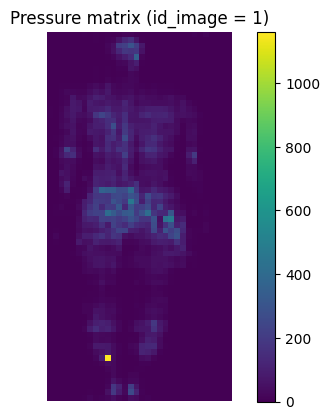

In [ ]:
def load_data(file_name, data_dir):
  if isinstance(data_dir, bytes):
    data_dir = data_dir.decode()
  if isinstance(file_name, bytes):
    file_name = file_name.decode()

  # Load the image from the .txt file
  file_mat = '/content/drive/MyDrive/HDA_project/' + data_dir + '/' + file_name + '.txt'
  data = np.loadtxt(file_mat)
  return data

## Example
data_dir = 'data'
file_name = '1'

image_example = load_data(file_name, data_dir)

plt.figure()
plt.imshow(image_example, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title(f'Pressure matrix (id_image = {file_name})')
plt.axis('off')
plt.show()

## 1.5 - Normalisation

We use a MinMaxScaler to normalise our data between 0 and 1.

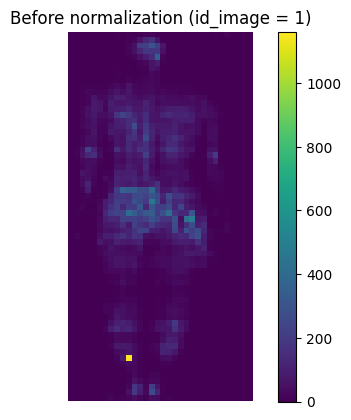

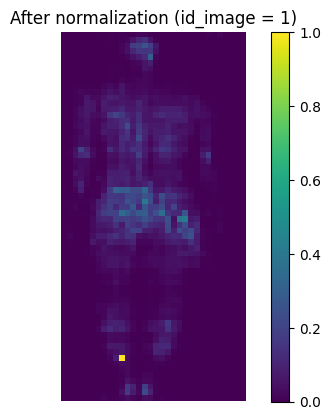

In [ ]:
def normalize_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    data = (data - min_val) / (max_val - min_val)
    return data

## Example
data_dir = 'data'
file_name = '1'

image_example = load_data(file_name, data_dir)
image_example_norm = normalize_data(image_example)

plt.figure()
plt.imshow(image_example, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title(f'Before normalization (id_image = {file_name})')
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(image_example_norm, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title(f'After normalization (id_image = {file_name})')
plt.axis('off')
plt.show()

## 1.6 - Filter

We use a gaussian filter to smooth our data and avoid outliers.

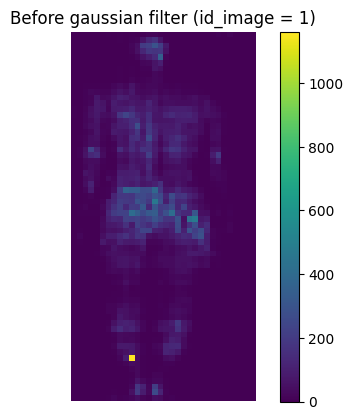

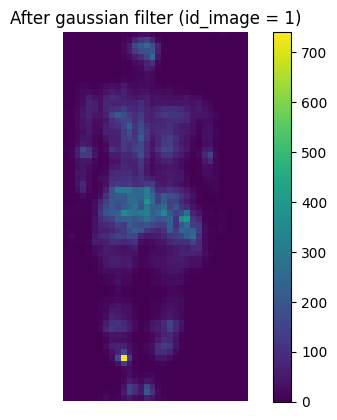

In [ ]:
def gaussian_filter_data(data):
  return ndimage.gaussian_filter(data,0.5)

## Example
data_dir = 'data'
file_name = '1'

image_example = load_data(file_name, data_dir)
image_example_filter = gaussian_filter_data(image_example)

plt.figure()
plt.imshow(image_example, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title(f'Before gaussian filter (id_image = {file_name})')
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(image_example_filter, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title(f'After gaussian filter (id_image = {file_name})')
plt.axis('off')
plt.show()

# 2 - Data Loading using the Dataset API

We create the load_and_preprocess_data function, which combines the three functions defined above.

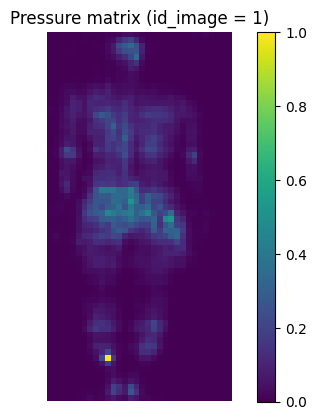

In [ ]:
def load_and_preprocess_data(file_name, data_dir):
    # Load data
    data = load_data(file_name, data_dir)

    # Filter
    data = gaussian_filter_data(data)

    # Normalize
    data = normalize_data(data)
    return data.astype(np.float32)

# Example
file_name = '1'
image_example = load_and_preprocess_data(file_name, data_dir)

plt.figure()
plt.imshow(image_example, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title(f'Pressure matrix (id_image = {file_name})')
plt.axis('off')
plt.show()

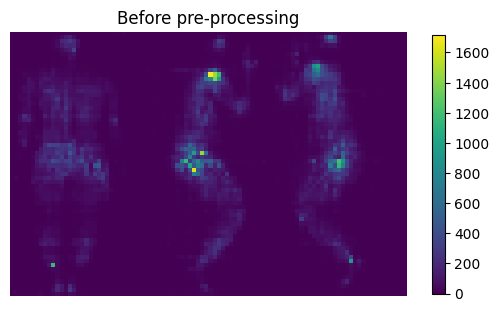

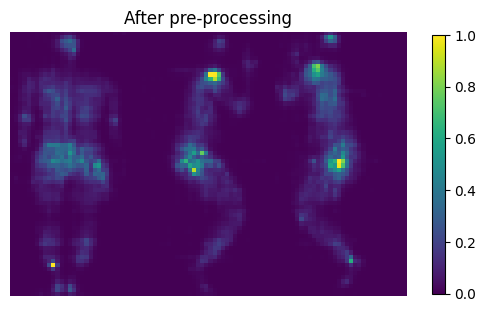

In [ ]:
id_image_supine = reference_df[reference_df['string_posture_label'] == 'Supine'].index[0]
id_image_right = reference_df[reference_df['string_posture_label'] == 'Right'].index[0]
id_image_left = reference_df[reference_df['string_posture_label'] == 'Left'].index[0]

supine_image_example = load_data(id_image_supine, data_dir)
right_image_example = load_data(id_image_right, data_dir)
left_image_example = load_data(id_image_left, data_dir)

supine_image_example_filter = load_and_preprocess_data(id_image_supine,data_dir)
right_image_example_filter = load_and_preprocess_data(id_image_right,data_dir)
left_image_example_filter = load_and_preprocess_data(id_image_left,data_dir)

image_example_concatenate = np.concatenate([supine_image_example,right_image_example,left_image_example], axis=1)
image_example_filter_concatenate = np.concatenate([supine_image_example_filter,right_image_example_filter,left_image_example_filter], axis=1)

plt.figure()
plt.imshow(image_example_concatenate, cmap='viridis', interpolation='nearest')
plt.title('Before pre-processing')
plt.colorbar(shrink=0.7)
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(image_example_filter_concatenate, cmap='viridis', interpolation='nearest')
plt.title('After pre-processing')
plt.colorbar(shrink=0.7)
plt.axis('off')
plt.show()

## 2.1 - Dataset definition

In [ ]:
def create_dataset(reference_df, batch_size, shuffle, cache_file=None):
  # Convert dataframe to lists
  file_names = list(reference_df.index)
  posture_labels = reference_df['posture_label']
  subject_labels = reference_df['subject_label']

  # Create a Dataset object
  dataset = tf.data.Dataset.from_tensor_slices((file_names, {'posture_output' : posture_labels,
                                                             'subject_output' : subject_labels}))

  # Map the load_and_preprocess_data function
  py_func = lambda file_name, label: (tf.numpy_function(load_and_preprocess_data, [file_name, data_dir],
                                                             tf.float32), label)
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Cache dataset
  if cache_file:
    dataset = dataset.cache(cache_file)

  # Shuffle
  if shuffle:
    dataset = dataset.shuffle(len(file_names))

  # Repeat the dataset indefinitely
  dataset = dataset.repeat()

  # Correct input shape for the network
  dataset = dataset.map(lambda data, label: (tf.reshape(data, [64,32,1]), label))

  # Batch
  dataset = dataset.batch(batch_size=batch_size)

  # Prefetch
  dataset = dataset.prefetch(buffer_size=1)

  return dataset

## 2.2 - Dataset initialization

In [ ]:
batch_size = 32
train_dataset = create_dataset(train_reference_df,
                               batch_size=batch_size,
                               shuffle=True,
                               cache_file='cache/train_cache')

val_dataset = create_dataset(val_reference_df,
                             batch_size=batch_size,
                             shuffle=False,
                             cache_file='cache/val_cache')


test_dataset = create_dataset(test_reference_df,
                             batch_size=batch_size,
                             shuffle=False,
                             cache_file='cache/test_cache')

train_steps = int(np.ceil(len(train_reference_df)/batch_size))
val_steps = int(np.ceil(len(val_reference_df)/batch_size))
test_steps = int(np.ceil(len(test_reference_df)/batch_size))

print(f'trains_steps = {train_steps}')
print(f'validations_steps = {val_steps}')
print(f'tests_steps = {test_steps}')

trains_steps = 414
validations_steps = 119
tests_steps = 60


# 3 - Model definition

In [ ]:
# Create and compile the network model (the models are defined in the cnn_models.py)
input_shape = (64, 32, 1)

SmallModel = SmallPostureAndSubjectModel(input_shape, dropout=False)
SmallModelWithDropout = SmallPostureAndSubjectModel(input_shape, dropout=True)

MediumModel = MediumPostureAndSubjectModel(input_shape, dropout=False)
MediumModelWithDropout = MediumPostureAndSubjectModel(input_shape, dropout=True)

LargeModel = LargePostureAndSubjectModel(input_shape, dropout=False)
LargeModelWithDropout = LargePostureAndSubjectModel(input_shape, dropout=True)

models_name = ['SmallModel', 'SmallModelWithDropout',
               'MediumModel', 'MediumModelWithDropout',
               'LargeModel', 'LargeModelWithDropout']

models_list = [SmallModel, SmallModelWithDropout,
               MediumModel, MediumModelWithDropout,
               LargeModel, LargeModelWithDropout]

for model in models_list:
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss={'posture_output': 'sparse_categorical_crossentropy',
                      'subject_output': 'sparse_categorical_crossentropy'},
                metrics=['accuracy'],
                weighted_metrics=[])

# 4 - Model training

In [ ]:
# Initialisation
num_epochs = 8
history_list = []
df_model_performances_scoreboard = pd.DataFrame(index=['Val_subject_accuracy',
                                                       'Val_posture_accuracy',
                                                       'Training time (s)',
                                                       'Parameters',
                                                       'Model size (MB)'])

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Create a custom callback to measure the training time for each model
class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

tc = TimingCallback()


# Fit the model
for model_name, model in zip(models_name, models_list):

  history = model.fit(train_dataset,
                      epochs=num_epochs,
                      steps_per_epoch=train_steps,
                      validation_data=val_dataset,
                      validation_steps=val_steps,
                      callbacks=[early_stop_callback, tc])
  history_list.append(history)

  # Update the variables
  model_val_subject_accuracy = history.history['val_posture_output_accuracy'][-1]
  model_val_posture_accuracy = history.history['val_subject_output_accuracy'][-1]
  training_time = sum(tc.logs)
  parameters_number = int(model.count_params())

  # Save the model
  model.save(f'models_saved/{model_name}.keras')
  file_size_in_bytes = os.path.getsize(f'models_saved/{model_name}.keras')
  file_size_in_kilobytes = file_size_in_bytes / 1024
  file_size_in_megabytes = file_size_in_kilobytes / 1024

  # Update the DataFrame of the model performances
  df_model_performances_scoreboard[model_name] = [np.round(model_val_subject_accuracy,4),
                                                  np.round(model_val_posture_accuracy,4),
                                                  np.round(training_time,1),
                                                  parameters_number,
                                                  np.round(file_size_in_megabytes,2)]

Epoch 1/8
414/414 [==============================] - 75s 45ms/step - loss: 0.8882 - posture_output_loss: 0.4053 - subject_output_loss: 0.4829 - posture_output_accuracy: 0.8880 - subject_output_accuracy: 0.8668 - val_loss: 2.0420 - val_posture_output_loss: 0.9719 - val_subject_output_loss: 1.0701 - val_posture_output_accuracy: 0.7891 - val_subject_output_accuracy: 0.8067
Epoch 2/8
414/414 [==============================] - 6s 14ms/step - loss: 0.0304 - posture_output_loss: 0.0164 - subject_output_loss: 0.0141 - posture_output_accuracy: 0.9968 - subject_output_accuracy: 0.9986 - val_loss: 0.0266 - val_posture_output_loss: 0.0072 - val_subject_output_loss: 0.0194 - val_posture_output_accuracy: 0.9992 - val_subject_output_accuracy: 0.9987
Epoch 3/8
414/414 [==============================] - 4s 10ms/step - loss: 0.0040 - posture_output_loss: 0.0018 - subject_output_loss: 0.0022 - posture_output_accuracy: 0.9998 - subject_output_accuracy: 0.9997 - val_loss: 0.0336 - val_posture_output_loss: 

# 5 - Model comparison

In [ ]:
df_model_performances_scoreboard.T

,Val_subject_accuracy,Val_posture_accuracy,Training time (s),Parameters,Model size (MB)
SmallModel,0.9992,0.9987,94.6,157950.0,1.89
SmallModelWithDropout,0.9609,0.9110,138.7,157950.0,1.89
MediumModel,0.9989,0.9992,179.6,239518.0,2.84
MediumModelWithDropout,0.9987,0.9989,227.6,239518.0,2.84
LargeModel,0.9992,0.9995,278.1,562398.0,6.54
LargeModelWithDropout,0.9984,0.9987,329.7,562398.0,6.54


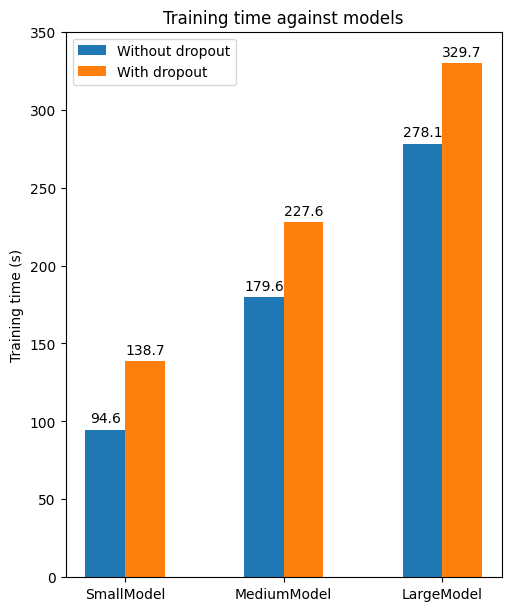

In [ ]:
short_models_list = ["SmallModel", "MediumModel", "LargeModel"]
dict = {
    'Without dropout': [df_model_performances_scoreboard['SmallModel']['Training time (s)'],
                        df_model_performances_scoreboard['MediumModel']['Training time (s)'],
                        df_model_performances_scoreboard['LargeModel']['Training time (s)']],

    'With dropout': [df_model_performances_scoreboard['SmallModelWithDropout']['Training time (s)'],
                     df_model_performances_scoreboard['MediumModelWithDropout']['Training time (s)'],
                     df_model_performances_scoreboard['LargeModelWithDropout']['Training time (s)']]
}

x = np.arange(len(short_models_list))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(5, 6), layout='constrained')

for attribute, measurement in dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Training time (s)')
ax.set_title('Training time against models')
ax.set_xticks(x + 0.125, short_models_list)
ax.legend(loc='upper left')
ax.set_ylim(0, 350)
plt.show()

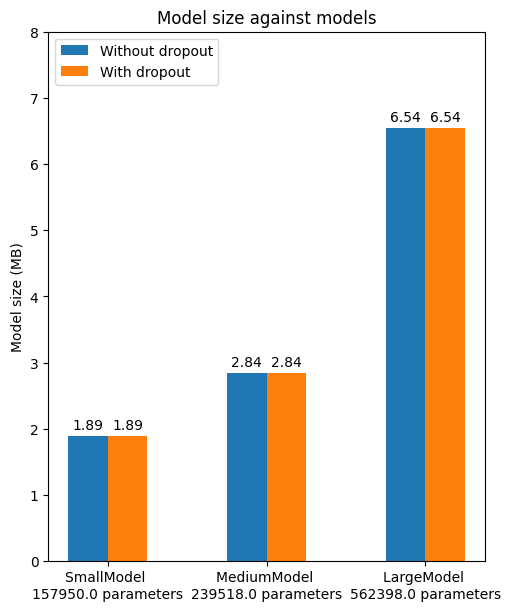

In [ ]:
params_SmallModel = df_model_performances_scoreboard['SmallModel']['Parameters']
params_MediumModel = df_model_performances_scoreboard['MediumModel']['Parameters']
params_LargeModel = df_model_performances_scoreboard['LargeModel']['Parameters']

short_models_list_with_parameters = [f'SmallModel \n{params_SmallModel} parameters',
                     f'MediumModel \n{params_MediumModel} parameters',
                     f'LargeModel \n{params_LargeModel} parameters']

dict = {
    'Without dropout': [df_model_performances_scoreboard['SmallModel']['Model size (MB)'],
                        df_model_performances_scoreboard['MediumModel']['Model size (MB)'],
                        df_model_performances_scoreboard['LargeModel']['Model size (MB)']],

    'With dropout': [df_model_performances_scoreboard['SmallModelWithDropout']['Model size (MB)'],
                     df_model_performances_scoreboard['MediumModelWithDropout']['Model size (MB)'],
                     df_model_performances_scoreboard['LargeModelWithDropout']['Model size (MB)']]
}

x = np.arange(len(short_models_list_with_parameters))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(5, 6), layout='constrained')

for attribute, measurement in dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model size (MB)')
ax.set_title('Model size against models')
ax.set_xticks(x + 0.125, short_models_list_with_parameters)
ax.legend(loc='upper left')
ax.set_ylim(0, 8)
plt.show()

Based on the results we have obtained, we choose the MediumWithDropout because :
- it gives us excellent results
- the model has relatively fast training time
- it is a compact model in terms of memory and parameters
- it prevents overfitting with the dropout

Keep in mind that : dropout is a technique widely used for preventing overfitting while training deep neural networks. However, applying dropout to a neural network typically increases the training time.

In [ ]:
best_model_name = models_name[3]
best_model = models_list[3]
best_model_history = history_list[3]

In [ ]:
best_model.summary()

Model: "MediumPostureAndSubjectModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64, 32, 1)]          0         []                            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 64, 32, 16)           160       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_10 (Ba  (None, 64, 32, 16)           64        ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_10 (Activation)  (None, 64, 32, 16)           0         ['b

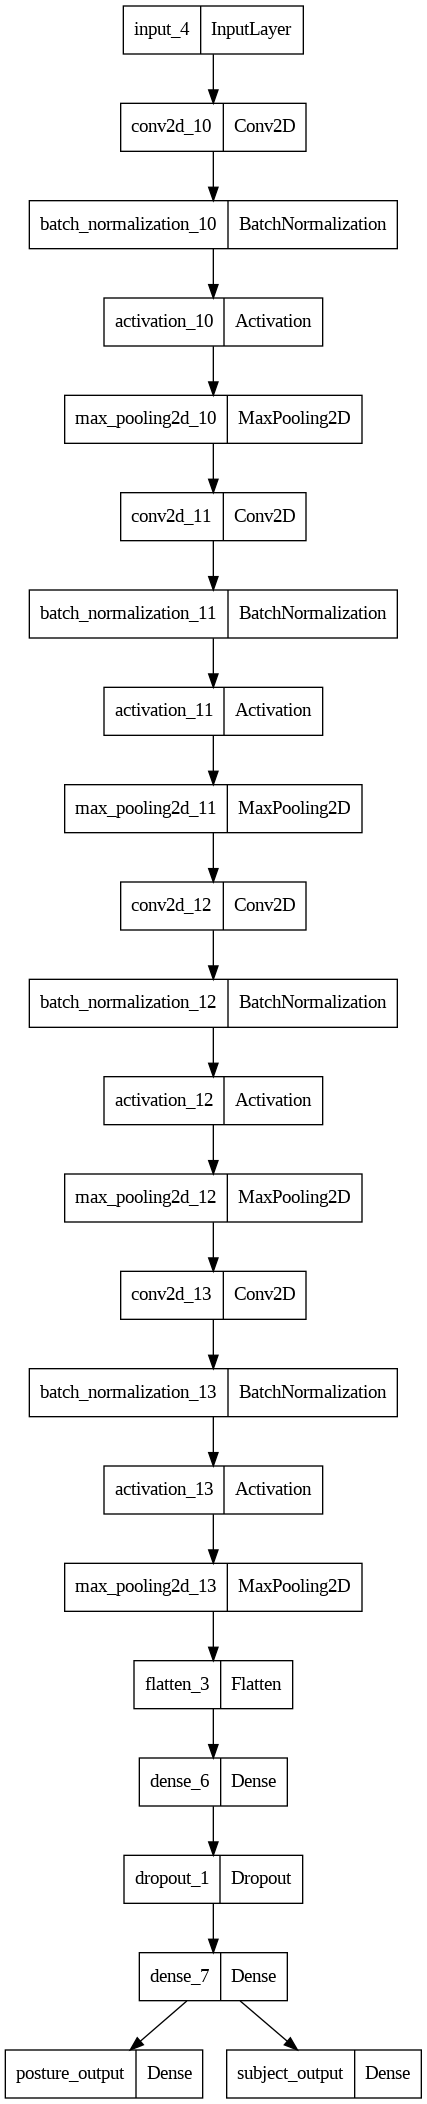

In [ ]:
plot_model(best_model, to_file='best_model.png')

Text(0, 0.5, 'Loss')

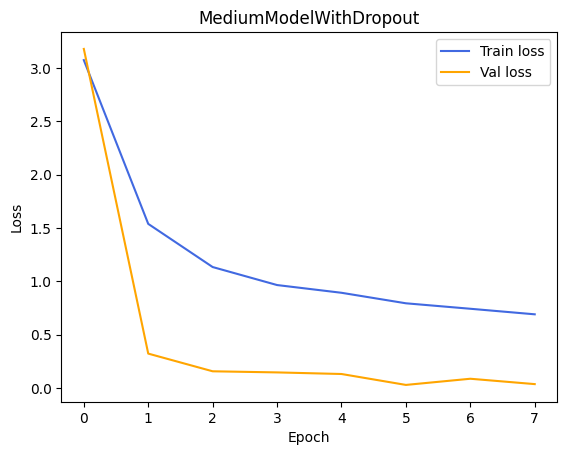

In [ ]:
# Plot model loss
plt.figure()
plt.title(f"{best_model_name}")
plt.plot(best_model_history.history['loss'], label='Train loss', color = 'royalblue')
plt.plot(best_model_history.history['val_loss'], label='Val loss', color = 'orange')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

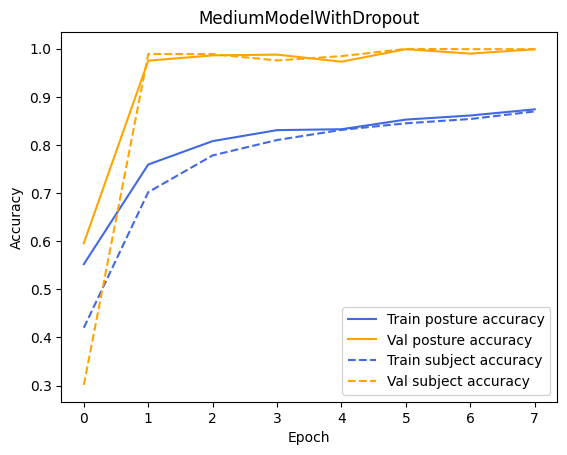

In [ ]:
# Plot posture and subject accuracy
plt.figure()
plt.title(f"{best_model_name}")
plt.plot(best_model_history.history['posture_output_accuracy'], label='Train posture accuracy', color='royalblue')
plt.plot(best_model_history.history['val_posture_output_accuracy'], label='Val posture accuracy', color='orange')
plt.plot(best_model_history.history['subject_output_accuracy'], label='Train subject accuracy', color='royalblue', linestyle='--')
plt.plot(best_model_history.history['val_subject_output_accuracy'], label='Val subject accuracy', color='orange', linestyle='--')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

The first thing to look at is the **orange curve** representing the validation set. You can see that the loss for the train is greater than the loss for the validation, which may be counter-intuitive. However, we have a model with a dropout which penalises the train set by deactivating 50% of the neurons. So, no worries here if the curves seem to be "inverted".

In fact, if we plot the same curves for the same model without the dropout, we get the curves in the "right order".

Text(0, 0.5, 'Loss')

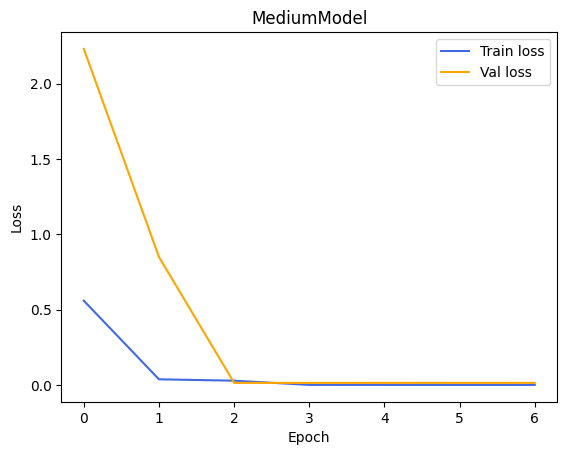

In [ ]:
# Plot model loss
plt.figure()
plt.title(f"{models_name[2]}")
plt.plot(history_list[2].history['loss'], label='Train loss', color = 'royalblue')
plt.plot(history_list[2].history['val_loss'], label='Val loss', color = 'orange')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

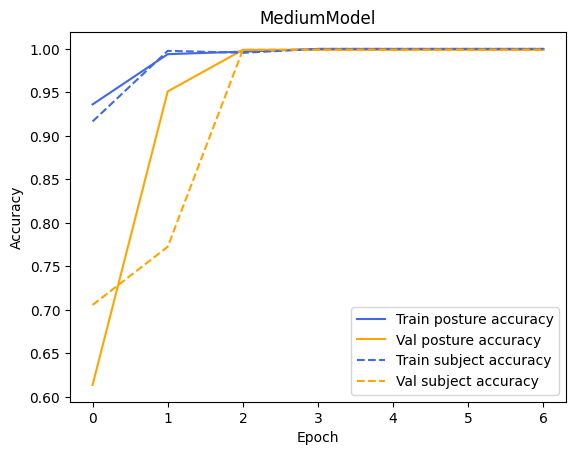

In [ ]:
# Plot posture and subject accuracy
plt.figure()
plt.title(f"{models_name[2]}")
plt.plot(history_list[2].history['posture_output_accuracy'], label='Train posture accuracy', color='royalblue')
plt.plot(history_list[2].history['val_posture_output_accuracy'], label='Val posture accuracy', color='orange')
plt.plot(history_list[2].history['subject_output_accuracy'], label='Train subject accuracy', color='royalblue', linestyle='--')
plt.plot(history_list[2].history['val_subject_output_accuracy'], label='Val subject accuracy', color='orange', linestyle='--')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# 6 - Model testing

We evaluate our best model only on the test set that are new value for the model.

In [ ]:
# Get the test labels
test_posture_labels = test_reference_df['posture_label'].values
test_subject_labels = test_reference_df['subject_label'].values

# Get the network output for the test set
start_time = time.time()
y_pred_posture = best_model.predict(test_dataset, steps=test_steps)[0][:len(test_posture_labels)].squeeze()
y_pred_subject = best_model.predict(test_dataset, steps=test_steps)[1][:len(test_subject_labels)].squeeze()

# Get the estimated classes (argmax to obtain the class with the higher probability)
y_pred_posture = np.argmax(y_pred_posture,axis=1)
y_pred_subject = np.argmax(y_pred_subject,axis=1)
end_time = time.time()
test_time = end_time - start_time

print(f'Number of images to predict = {test_reference_df.shape[0]}')
print(f'Number of steps for the test set = {test_steps}')
print(f'Time to predict a batch = {round(test_time/test_steps,2)}')
print(f'Time to predict an image = {round(test_time/test_reference_df.shape[0],4)}')

60/60 [==============================] - 0s 4ms/step
Number of images to predict = 1892
Number of steps for the test set = 60
Time to predict a batch = 0.12
Time to predict an image = 0.0038


In [ ]:
# Concatenate in a Dataframe the test and the predicted labels
dict = {'string_posture_label': test_reference_df['string_posture_label'],
        'posture_label': test_posture_labels,
        'predicted_posture_label': y_pred_posture,
        'subject_label': test_subject_labels,
        'predicted_subject_label': y_pred_subject}

predicted_df = pd.DataFrame(data=dict, index=test_reference_df.index)

## 6.1 - Confusion matrix

Here we sort the labels to have in order supine, right and left postures

In [ ]:
string_posture_label_sorted = ['Supine','Supine star','Supine Hand Crossed','Supine Knees up','Supine Right Knee up','Supine Left Knee up','Supine 30° Bed Inclination','Supine 45° Bed Inclination','Supine 60° Bed Inclination',
                               'Right','Right 30°-roll','Right 60°-roll','Right Fetus',
                               'Left','Left 30°-roll','Left 60°-roll','Left Fetus']

labels_posture_label_sorted = [0,7,8,9,10,11,14,15,16,
                               1,3,4,12,
                               2,5,6,13]

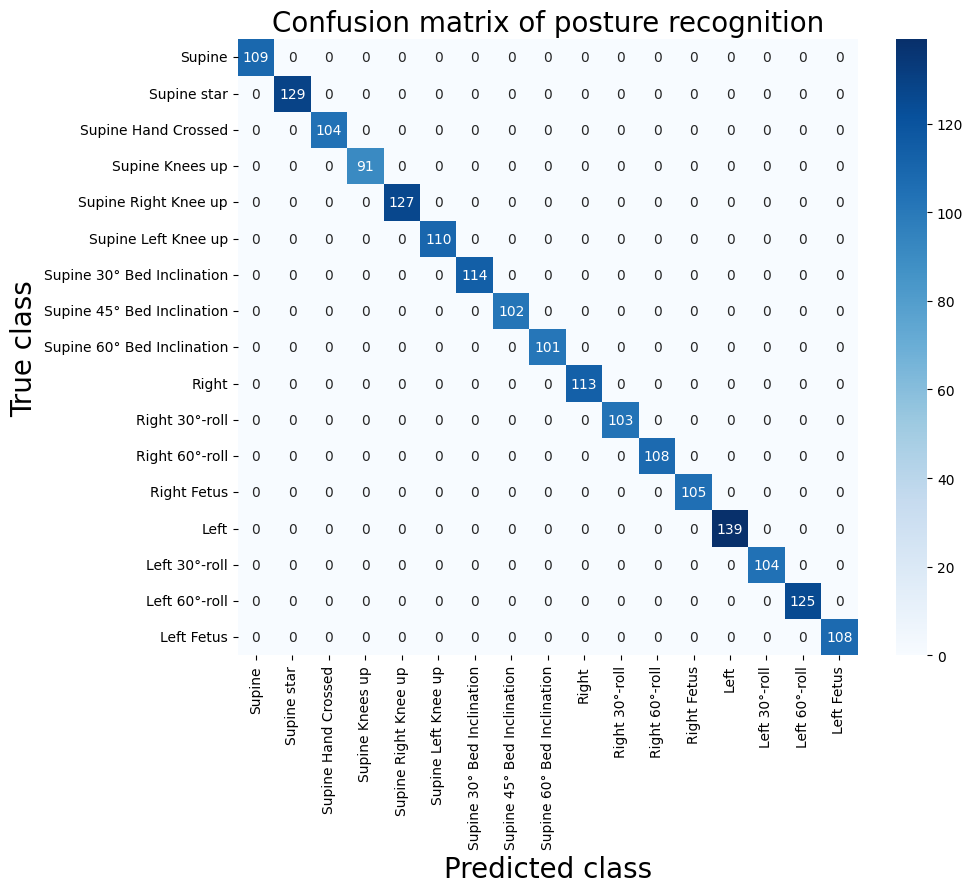

In [ ]:
posture_confusion_matrix = confusion_matrix(y_true=test_posture_labels, y_pred=y_pred_posture, labels=labels_posture_label_sorted)

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot()
sns.heatmap(posture_confusion_matrix, annot=True, ax = ax, fmt = 'g',cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted class', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(string_posture_label_sorted, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True class', fontsize=20)
ax.yaxis.set_ticklabels(string_posture_label_sorted, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion matrix of posture recognition', fontsize=20)

plt.show()

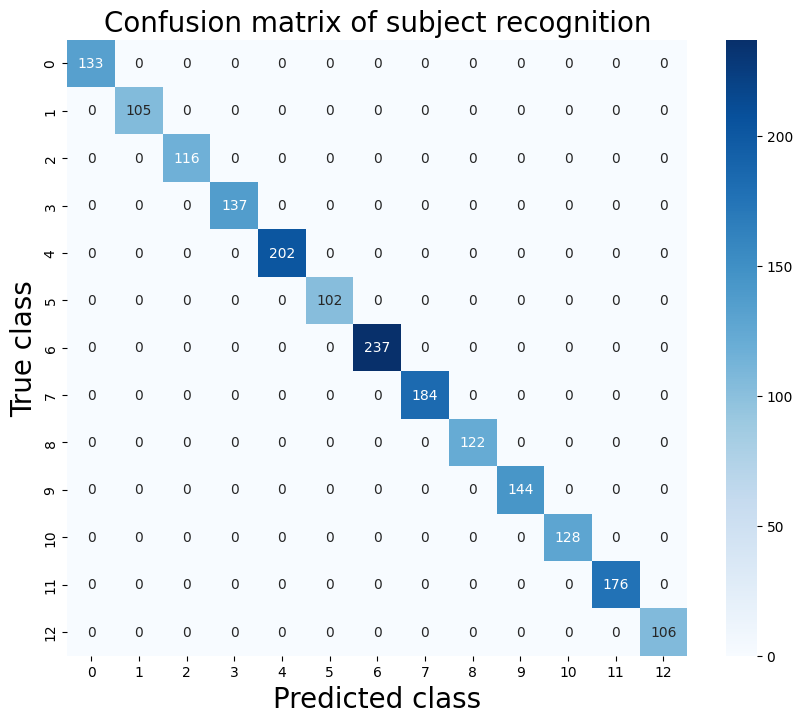

In [ ]:
subject_confusion_matrix = confusion_matrix(y_true=test_subject_labels, y_pred=y_pred_subject)

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot()
sns.heatmap(subject_confusion_matrix, annot=True, ax = ax, fmt = 'g',cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted class', fontsize=20)
ax.set_ylabel('True class', fontsize=20)
plt.title('Confusion matrix of subject recognition', fontsize=20)
plt.show()

## 6.2 - Metrics (accuracy, precision, recall, f1-score)

### For the whole model

In [ ]:
# Evaluate accuracy
posture_accuracy = accuracy_score(test_posture_labels, y_pred_posture)
subject_accuracy = accuracy_score(test_subject_labels, y_pred_subject)

# Evaluate precision, recall and fscore
posture_precision, posture_recall, posture_fscore, _= precision_recall_fscore_support(test_posture_labels, y_pred_posture)
subject_precision, subject_recall, subject_fscore, _= precision_recall_fscore_support(test_subject_labels, y_pred_subject)

#Take the mean and approximate with 2 digits
posture_accuracy = np.round(posture_accuracy*100,3)
posture_precision = np.round(np.mean(posture_precision)*100,3)
posture_recall = np.round(np.mean(posture_recall)*100,3)
posture_fscore = np.round(np.mean(posture_fscore)*100,3)

subject_accuracy = np.round(subject_accuracy*100,3)
subject_precision = np.round(np.mean(subject_precision)*100,3)
subject_recall = np.round(np.mean(subject_recall)*100,3)
subject_fscore = np.round(np.mean(subject_fscore)*100,3)

#Create a dict to save the values and a DataFrame to display them
dict = {'Accuracy (%)': [posture_accuracy, subject_accuracy],
        'Average precision (%)': [posture_precision, subject_precision],
        'Average recall (%)': [posture_recall, subject_recall],
        'Average f1-score (%)': [posture_fscore, subject_fscore]
}

df_global_performance_scoreboard = pd.DataFrame(data=dict, index = ['Posture', 'Subject'])
df_global_performance_scoreboard

,Accuracy (%),Average precision (%),Average recall (%),Average f1-score (%)
Posture,100.0,100.0,100.0,100.0
Subject,100.0,100.0,100.0,100.0


### Only for supline, right and left postures

Here, we want to calculate the accuracy for specific postures. The accuracy is mesured as all correct / all instances.

In [ ]:
def predict_main_postures(matrix):
  correct_classified_supine = 0
  correct_classified_right = 0
  correct_classified_left = 0

  miss_classified_supine = 0
  miss_classified_right = 0
  miss_classified_left = 0

  # Supine
  for i in range(0,9):
    for j in range(0,9):
      correct_classified_supine = correct_classified_supine + matrix[i,j]
    for j in range(9,17):
      miss_classified_supine = miss_classified_supine + matrix[i,j]

  # Right
  for i in range(9,13):
    for j in range(9,13):
      correct_classified_right = correct_classified_right + matrix[i,j]
    for j in range(0,9):
      miss_classified_right = miss_classified_right + matrix[i,j]
    for j in range(13,17):
      miss_classified_right = miss_classified_right + matrix[i,j]

  # Left
  for i in range(13,17):
    for j in range(13,17):
      correct_classified_left = correct_classified_left + matrix[i,j]
    for j in range(0,13):
      miss_classified_left = miss_classified_left + matrix[i,j]

  accuracy_supine = round(correct_classified_supine / (correct_classified_supine + miss_classified_supine),3)
  accuracy_right = round(correct_classified_right / (correct_classified_right + miss_classified_right),3)
  accuracy_left = round(correct_classified_left / (correct_classified_left + miss_classified_left),3)

  total_number_of_miss_classified = miss_classified_supine + miss_classified_right + miss_classified_left

  return accuracy_supine, accuracy_right, accuracy_left, total_number_of_miss_classified

In [ ]:
accuracy_supine, accuracy_right, accuracy_left, total_number_of_miss_classified = predict_main_postures(posture_confusion_matrix)
print(f'Supine accuracy : {accuracy_supine}')
print(f'Right accuracy : {accuracy_right}')
print(f'Left accuracy : {accuracy_left}')
print(f'Number of image(s) miss classified : {total_number_of_miss_classified}')

Supine accuracy : 1.0
Right accuracy : 1.0
Left accuracy : 1.0
Number of image(s) miss classified : 0


## 6.3 - k-fold cross validation

In order to confirm our model, we will perform a 10-fold cross validations on the data with 90% of the data for the training and 10% for the validation.

This will enable us to compare the performance of our model over several samples and obtain more reliable results.

The results of each cross validation will be stored in the df_model_performances_scoreboard_on_validation DataFrame, and we will add up the results of the confusion matrices.

In [ ]:
input_shape = (64, 32, 1)
batch_size = 32
num_epochs = 8
kf = KFold(n_splits = 10, random_state = 123, shuffle = True)

df_model_performances_scoreboard_on_validation = pd.DataFrame(index=['Posture accuracy (%)',
                                                                     'Posture average precision (%)',
                                                                     'Posture average recall (%)',
                                                                     'Posture average f1-score (%)',
                                                                     'Subject accuracy (%)',
                                                                     'Subject average precision (%)',
                                                                     'Subject average recall (%)',
                                                                     'Subject average f1-score (%)'])

num_posture = len(reference_df['posture_label'].unique())
num_subject = len(reference_df['subject_label'].unique())

posture_confusion_matrix = np.zeros((num_posture,num_posture))
subject_confusion_matrix = np.zeros((num_subject,num_subject))

In [ ]:
i = 0

for train_index, val_index in kf.split(reference_df) :

  i = i + 1

  # Create the train and the validation (-1 to have the same index between the df and the list with iloc)
  train_k_fold_reference_df = reference_df.iloc[train_index-1]
  val_k_fold_reference_df = reference_df.iloc[val_index-1]

  MediumModelWithDropout = MediumPostureAndSubjectModel(input_shape, dropout=True)
  MediumModelWithDropout.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                                  loss={'posture_output': 'sparse_categorical_crossentropy',
                                        'subject_output': 'sparse_categorical_crossentropy'},
                                  metrics=['accuracy'],
                                  weighted_metrics=[])

  # Create datasets and steps
  train_k_fold_dataset = create_dataset(train_k_fold_reference_df,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  cache_file=f'cache/train_cache_{i}')

  val_k_fold_dataset = create_dataset(val_k_fold_reference_df,
                                batch_size=batch_size,
                                shuffle=False,
                                cache_file=f'cache/val_cache_{i}')

  train_steps = int(np.ceil(len(train_k_fold_reference_df)/batch_size))
  val_steps = int(np.ceil(len(val_k_fold_reference_df)/batch_size))

  # Fit the model
  history = MediumModelWithDropout.fit(train_k_fold_dataset,
                                       epochs=num_epochs,
                                       steps_per_epoch=train_steps,
                                       validation_data=val_k_fold_dataset,
                                       validation_steps=val_steps,
                                       callbacks=[early_stop_callback, tc])

  # Get the real validation labels for this split
  val_posture_labels = val_k_fold_reference_df['posture_label'].values
  val_subject_labels = val_k_fold_reference_df['subject_label'].values

  # Get the network output for the validation set
  y_pred_posture = MediumModelWithDropout.predict(val_k_fold_dataset, steps=val_steps)[0][:len(val_posture_labels)].squeeze()
  y_pred_subject = MediumModelWithDropout.predict(val_k_fold_dataset, steps=val_steps)[1][:len(val_subject_labels)].squeeze()

  # Get the estimated classes (argmax to obtain the class with the higher probability)
  y_pred_posture = np.argmax(y_pred_posture,axis=1)
  y_pred_subject = np.argmax(y_pred_subject,axis=1)

  # Compute the confusion matrix and add it to the previous matrix
  posture_confusion_matrix = np.add(posture_confusion_matrix,
                                    confusion_matrix(y_true=val_posture_labels,
                                                     y_pred=y_pred_posture,
                                                     labels=labels_posture_label_sorted))

  subject_confusion_matrix = np.add(subject_confusion_matrix,
                                    confusion_matrix(y_true=val_subject_labels,
                                                     y_pred=y_pred_subject))

  # Evaluate accuracy on this split
  posture_accuracy = accuracy_score(val_posture_labels, y_pred_posture)
  subject_accuracy = accuracy_score(val_subject_labels, y_pred_subject)

  # Evaluate precision, recall and fscore on this split
  posture_precision, posture_recall, posture_fscore, _= precision_recall_fscore_support(val_posture_labels, y_pred_posture)
  subject_precision, subject_recall, subject_fscore, _= precision_recall_fscore_support(val_subject_labels, y_pred_subject)

  # Update the DataFrame of the model performances
  df_model_performances_scoreboard_on_validation[i] = [posture_accuracy*100,
                                                       np.mean(posture_precision)*100,
                                                       np.mean(posture_recall)*100,
                                                       np.mean(posture_fscore)*100,
                                                       subject_accuracy*100,
                                                       np.mean(subject_precision)*100,
                                                       np.mean(subject_recall)*100,
                                                       np.mean(subject_fscore)*100]

Epoch 1/8
533/533 [==============================] - 83s 33ms/step - loss: 2.3115 - posture_output_loss: 1.0273 - subject_output_loss: 1.2842 - posture_output_accuracy: 0.6592 - subject_output_accuracy: 0.5709 - val_loss: 1.1507 - val_posture_output_loss: 0.4970 - val_subject_output_loss: 0.6537 - val_posture_output_accuracy: 0.8656 - val_subject_output_accuracy: 0.8104
Epoch 2/8
533/533 [==============================] - 6s 11ms/step - loss: 0.8235 - posture_output_loss: 0.4016 - subject_output_loss: 0.4219 - posture_output_accuracy: 0.8573 - subject_output_accuracy: 0.8517 - val_loss: 0.0550 - val_posture_output_loss: 0.0267 - val_subject_output_loss: 0.0283 - val_posture_output_accuracy: 0.9937 - val_subject_output_accuracy: 1.0000
Epoch 3/8
533/533 [==============================] - 7s 13ms/step - loss: 0.6023 - posture_output_loss: 0.3006 - subject_output_loss: 0.3018 - posture_output_accuracy: 0.8935 - subject_output_accuracy: 0.8931 - val_loss: 0.0430 - val_posture_output_loss: 

Confusion matrix

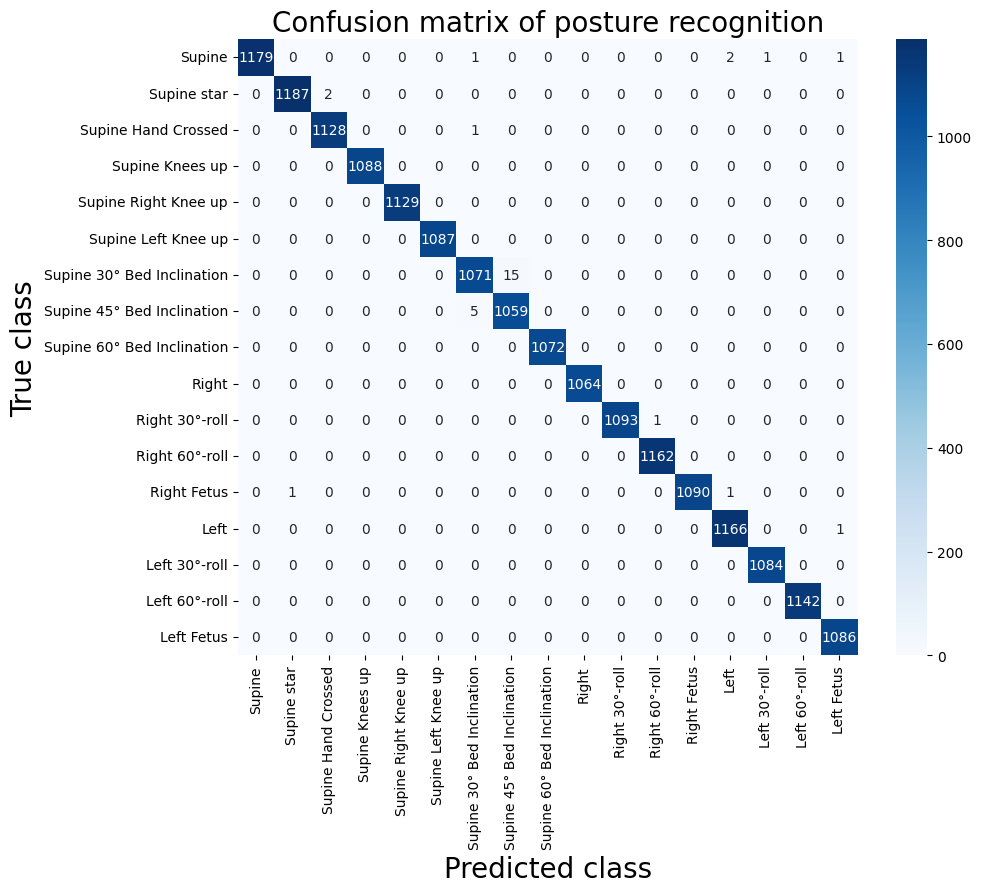

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot()
sns.heatmap(posture_confusion_matrix, annot=True, ax = ax, fmt = 'g',cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted class', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(string_posture_label_sorted, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True class', fontsize=20)
ax.yaxis.set_ticklabels(string_posture_label_sorted, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion matrix of posture recognition', fontsize=20)

plt.show()

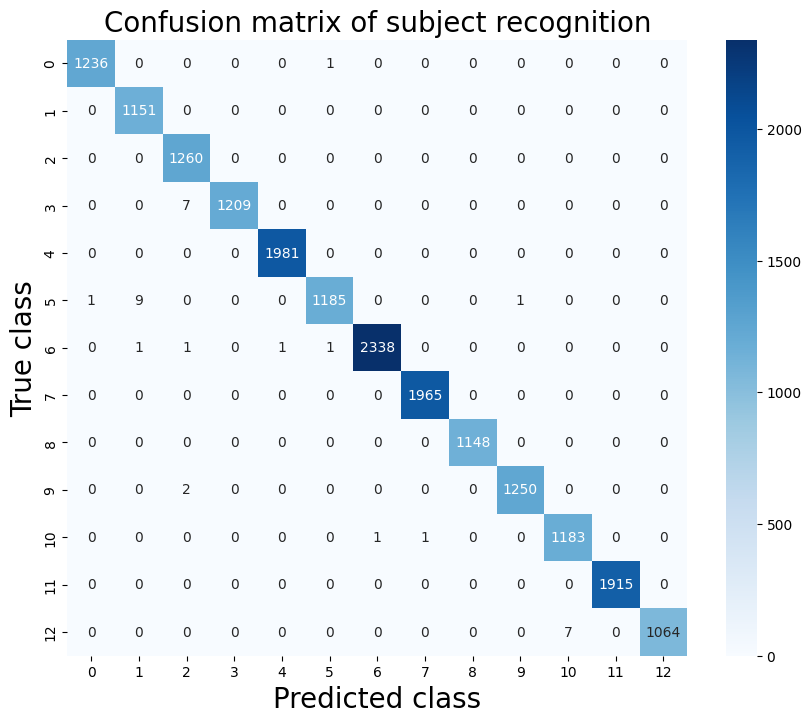

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot()
sns.heatmap(subject_confusion_matrix, annot=True, ax = ax, fmt = 'g',cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted class', fontsize=20)
ax.set_ylabel('True class', fontsize=20)
plt.title('Confusion matrix of subject recognition', fontsize=20)

plt.show()

For the whole model

In [ ]:
df_model_performances_scoreboard_on_validation

,1,2,3,4,5,6,7,8,9,10
Posture accuracy (%),99.894292,99.841438,99.947146,99.947146,99.947146,99.260042,99.682875,99.841438,99.947146,100.000000
Posture average precision (%),99.888973,99.845938,99.949723,99.946524,99.949290,99.309174,99.676201,99.837643,99.945025,100.000000
Posture average recall (%),99.902908,99.836474,99.952176,99.950568,99.957681,99.279774,99.708313,99.845189,99.951386,100.000000
Posture average f1-score (%),99.895473,99.840277,99.950744,99.948320,99.953299,99.255426,99.685010,99.840696,99.947975,100.000000
Subject accuracy (%),100.000000,99.894292,100.000000,98.625793,100.000000,99.947146,99.894292,99.894292,100.000000,99.947118
Subject average precision (%),100.000000,99.901663,100.000000,98.473372,100.000000,99.943020,99.876187,99.898304,100.000000,99.960143
Subject average recall (%),100.000000,99.891140,100.000000,98.300178,100.000000,99.929428,99.908711,99.910425,100.000000,99.965193
Subject average f1-score (%),100.000000,99.896018,100.000000,98.334069,100.000000,99.935956,99.892052,99.904106,100.000000,99.962577


In [ ]:
df_model_performances_scoreboard_on_validation.mean(axis=1)

Posture accuracy (%)             99.830867
Posture average precision (%)    99.834849
Posture average recall (%)       99.838447
Posture average f1-score (%)     99.831722
Subject accuracy (%)             99.820293
Subject average precision (%)    99.805269
Subject average recall (%)       99.790508
Subject average f1-score (%)     99.792478
dtype: float64

Only for supline, right and left postures

In [ ]:
accuracy_supine, accuracy_right, accuracy_left, total_number_of_miss_classified = predict_main_postures(posture_confusion_matrix)
print(f'Supine accuracy : {accuracy_supine}')
print(f'Right accuracy : {accuracy_right}')
print(f'Left accuracy : {accuracy_left}')
print(f'Number of image(s) miss classified : {total_number_of_miss_classified}')

Supine accuracy : 1.0
Right accuracy : 1.0
Left accuracy : 1.0
Number of image(s) miss classified : 6.0


Rounding 3 digits after the decimal point means that the accuracy of supine and right are equal to 1 whereas in the realized it is rather 0.9999..

# 7 - Prediction on images

Now we are going to display our predictions and current labels on different images of the test set with our best model previously train (reminder: our best model was trained once with 70% of the training set and selected with 20% of the validation set. Now we use the 10% of the test set that the model has never seen for our predictions.)

In [ ]:
def plot_multiple_predicted_images(predicted_df, n, data_dir):
  """
   Arguments:
   predicted_df -- DataFrame containing the true and the predicted labels from the test dataset
   n -- number of images to display
   data_dir -- name of the directory where the data are stored

   Returns:
   images with the true and predicted labels
   """

  for index in range(0,n):

    # Get the image from the test set
    file_name = predicted_df.iloc[index,:].name
    image = load_data(file_name, data_dir)

    # Actual labels
    string_posture_label = predicted_df.loc[file_name, 'string_posture_label']
    subject_label = predicted_df.loc[file_name, 'subject_label']
    posture_label = predicted_df.loc[file_name, 'posture_label']

    # Predicted labels
    predicted_subject_label = predicted_df.loc[file_name, 'predicted_subject_label']
    predicted_posture_label = predicted_df.loc[file_name, 'predicted_posture_label']

    # Plot
    plt.figure()
    plt.imshow(image, cmap='viridis', interpolation='nearest')
    plt.title(f"id_image : {file_name} \n {string_posture_label} \n (Subject, posture): {subject_label, posture_label} \n Predicted : {predicted_subject_label, predicted_posture_label}")
    plt.axis('off')
    plt.show()

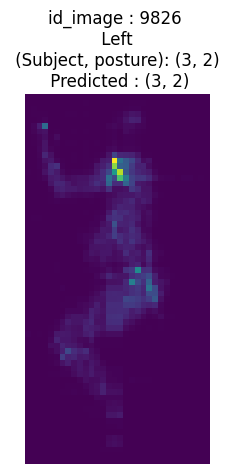

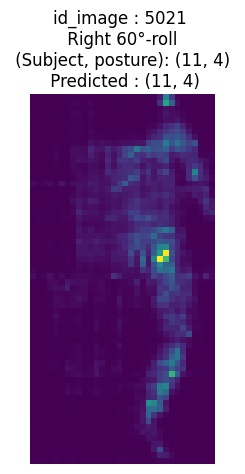

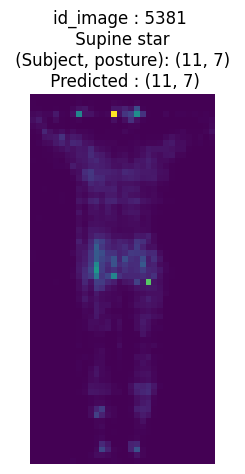

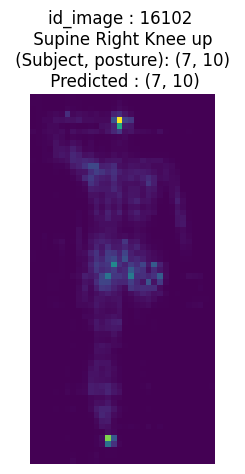

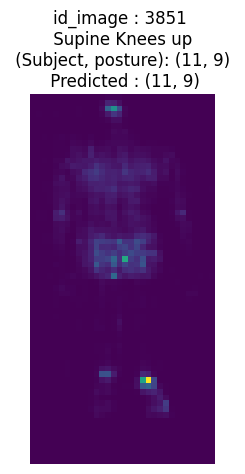

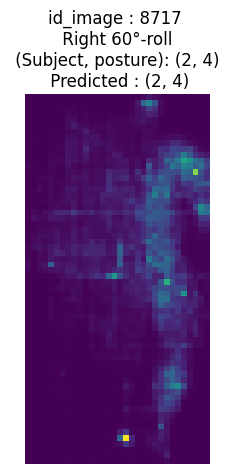

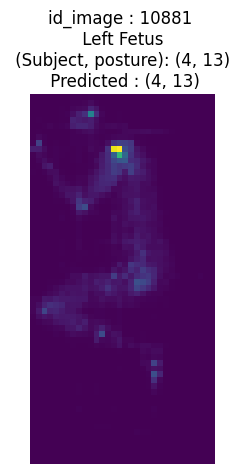

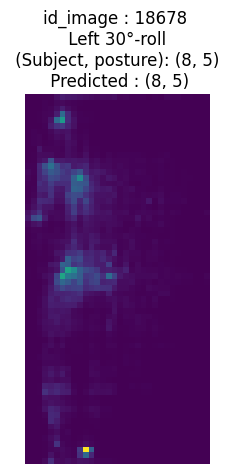

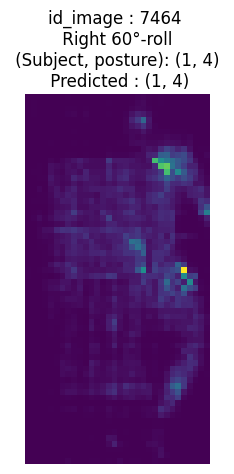

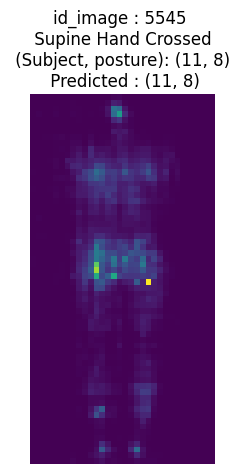

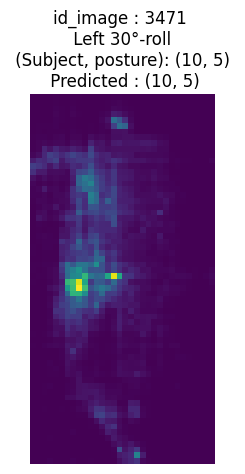

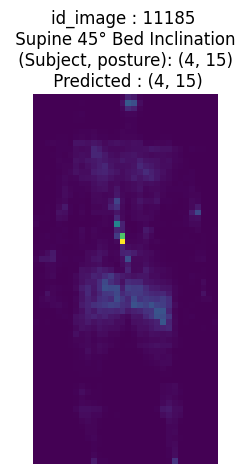

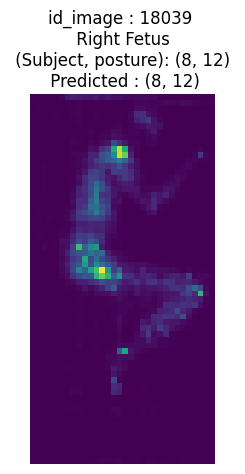

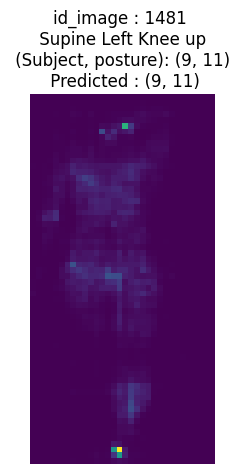

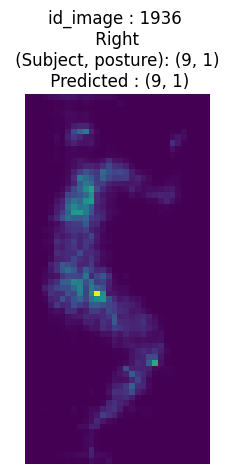

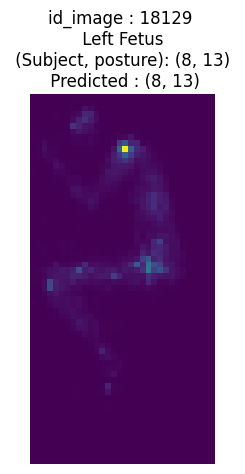

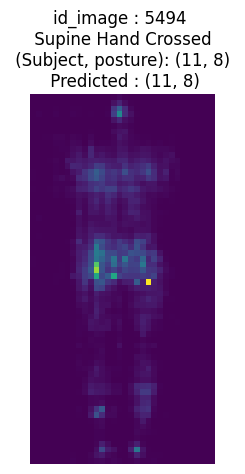

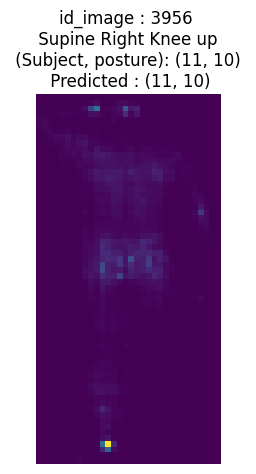

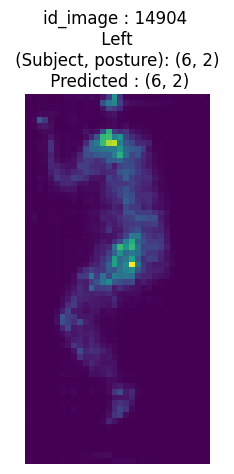

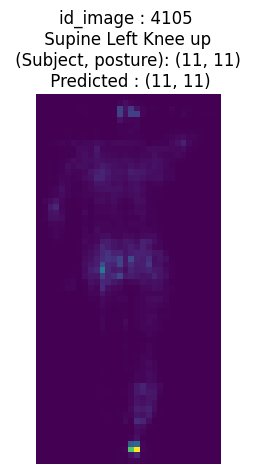

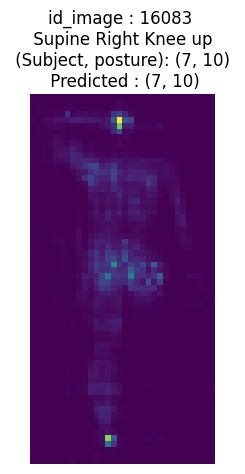

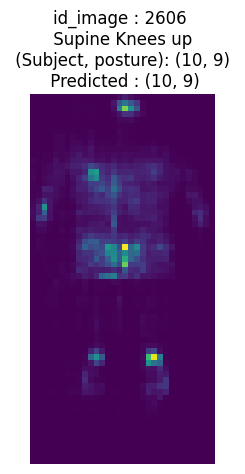

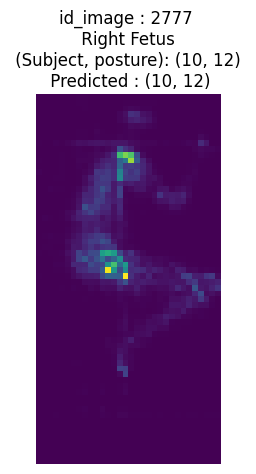

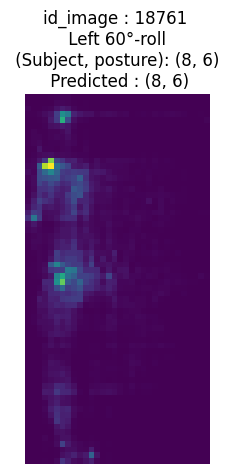

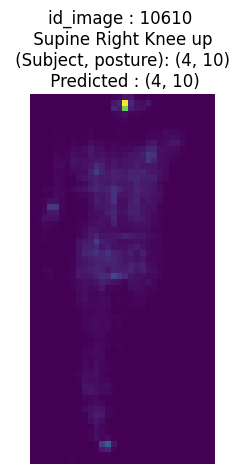

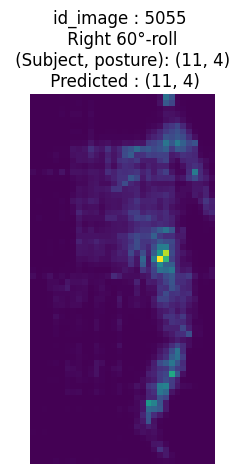

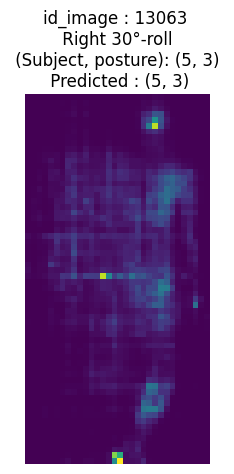

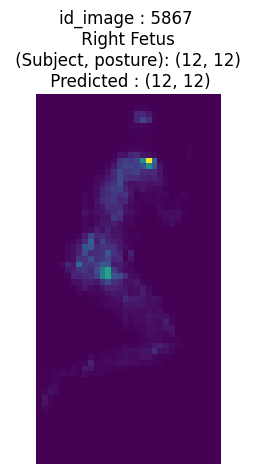

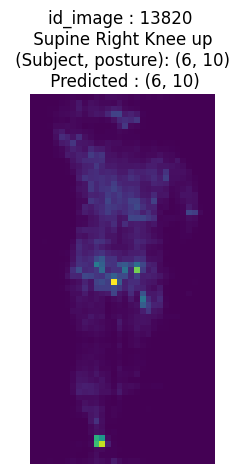

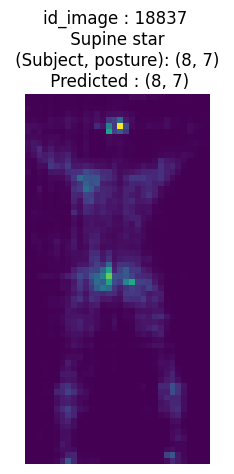

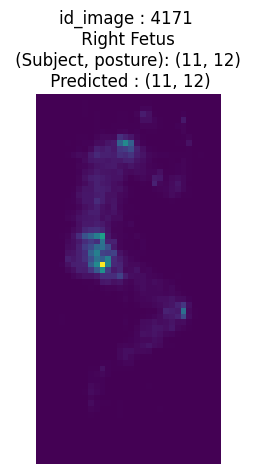

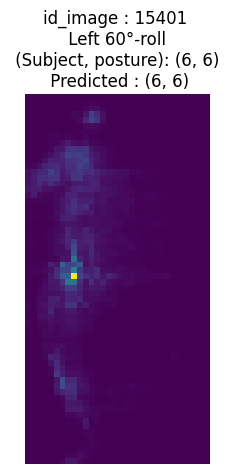

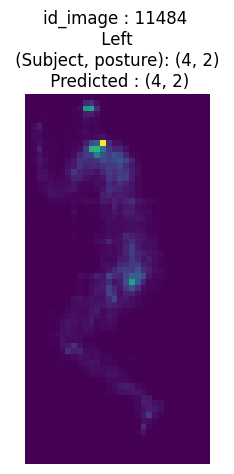

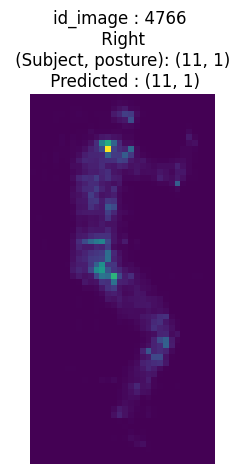

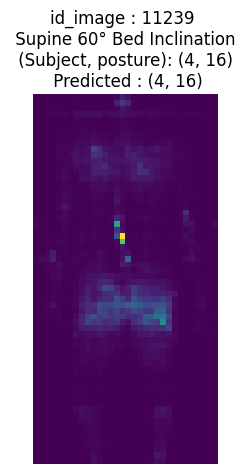

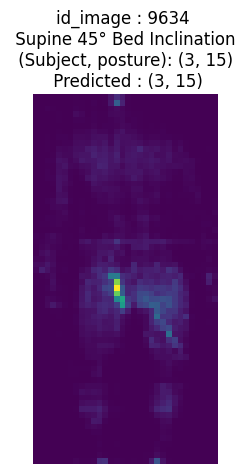

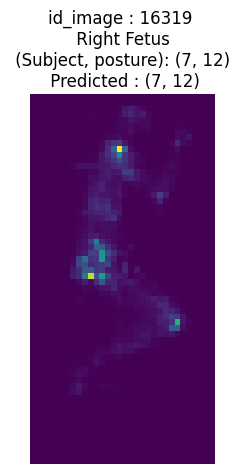

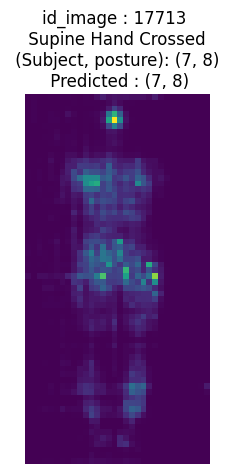

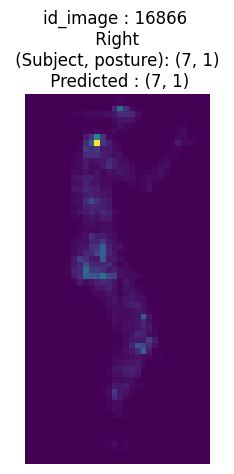

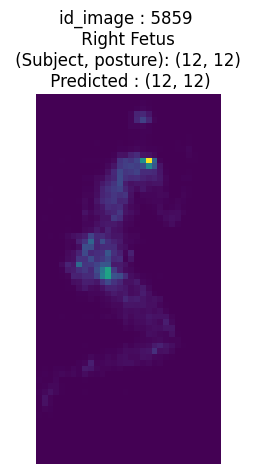

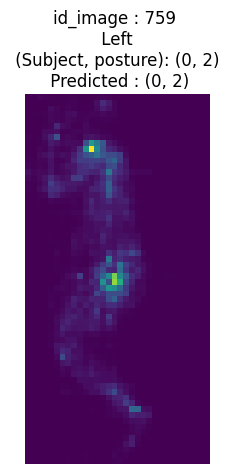

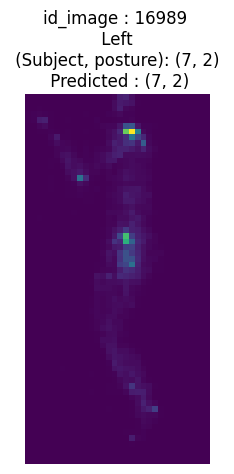

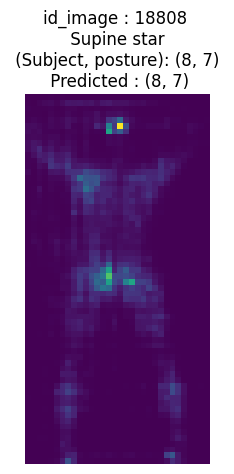

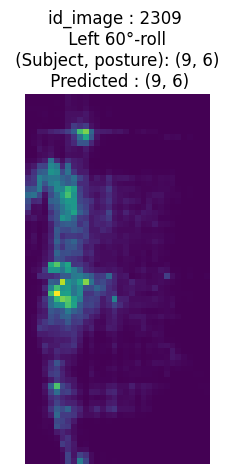

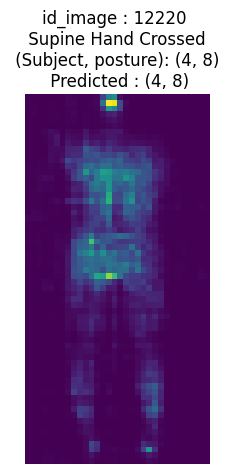

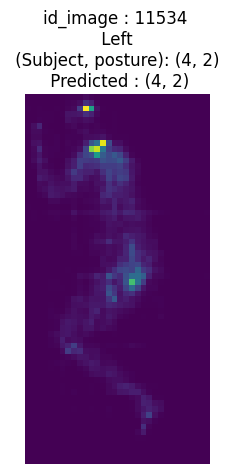

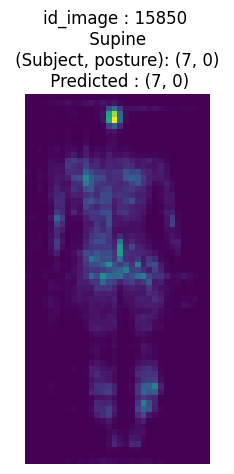

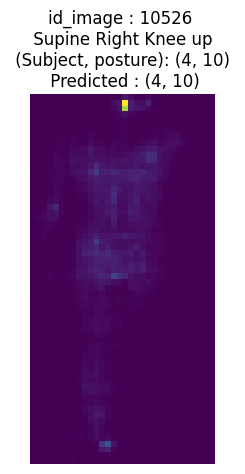

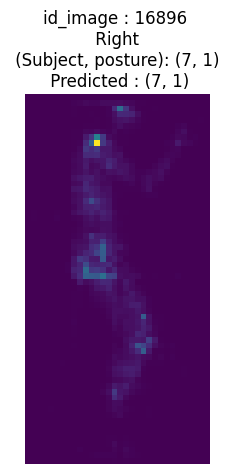

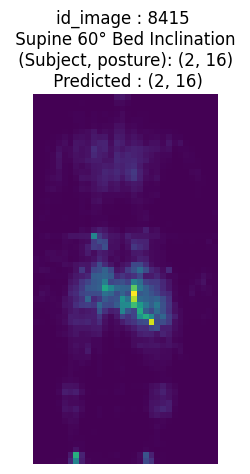

In [ ]:
plot_multiple_predicted_images(predicted_df, 50, data_dir='data')